In [1]:
from src.agents import ETFTrader, FundamentalTrader, TrendTrader, MeanReversionTrader, ZeroIntelligenceTrader
from src.core import Engine

In [2]:
TOTAL_CASH = 1_000_000
ZI_SHARE = 0.3642
TECH_TREND_SHARE = 0.1686
TECH_REVERSION_SHARE = 0.0321
FUNDAMENTAL_SHARE = 0.1715
ETF_SHARE = 0.2636
assert ZI_SHARE + TECH_TREND_SHARE + TECH_REVERSION_SHARE + FUNDAMENTAL_SHARE + ETF_SHARE == 1

INITIAL_PRICE = 100
N_STEPS = 500

# Инициализация агентов

In [3]:
def init_zi_agents(cash: float = 500, noise: float = 0.1) -> list[ZeroIntelligenceTrader]:
    return [
        ZeroIntelligenceTrader(
            cash=cash, 
            noise=noise,
        ) for i in range(round(TOTAL_CASH * ZI_SHARE / cash))
    ]

def init_tech_trend_agents(windows_size: list[int] = [6, 7, 8, 9], pct: float = 0.05) -> list[TrendTrader]:
    return [
        TrendTrader(
            cash=(TOTAL_CASH * TECH_TREND_SHARE) * (window_size / sum(windows_size)), 
            window_size=window_size,
            pct=pct,
        ) for window_size in windows_size
    ]

def init_tech_reversion_agents(windows_size: list[int] = [2, 3, 4, 5], pct: float = 0.05) -> list[MeanReversionTrader]:
    return [
        MeanReversionTrader(
            cash=(TOTAL_CASH * TECH_REVERSION_SHARE) * (window_size / sum(windows_size)), 
            window_size=window_size,
            pct=pct,
        ) for window_size in windows_size
    ]

def init_fundamental_agents(
    mu: float = 0.000185, 
    sigma: float = 0.000199, 
    min: float = (1 - 0.06) ** (1 / 90) - 1, 
    max: float = (1 + 0.06) ** (1 / 90) - 1,
    pct: float = 0.05,
) -> list[FundamentalTrader]:
    return [
        FundamentalTrader(
            cash=TOTAL_CASH * FUNDAMENTAL_SHARE,
            mu=mu,
            sigma=sigma,
            pct=pct,
            min=min,
            max=max,
        )
    ]

def init_etf_agents(pct: float = 0.1) -> list[ETFTrader]:
    return [
        ETFTrader(
            cash=TOTAL_CASH * ETF_SHARE,
            pct=pct,
        )
    ]

In [4]:
agents = (
    init_zi_agents()
    + init_tech_trend_agents()
    + init_tech_reversion_agents()
    + init_fundamental_agents()
    + init_etf_agents()
)

# Запуск симуляции

In [5]:
engine = Engine()
engine.run(
    agents=agents,
    initial_price=INITIAL_PRICE,
    n_steps=N_STEPS,
)

100%|████████████████████████████████████████| 500/500 [00:03<00:00, 127.72it/s]


# Визуализация и анализ

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

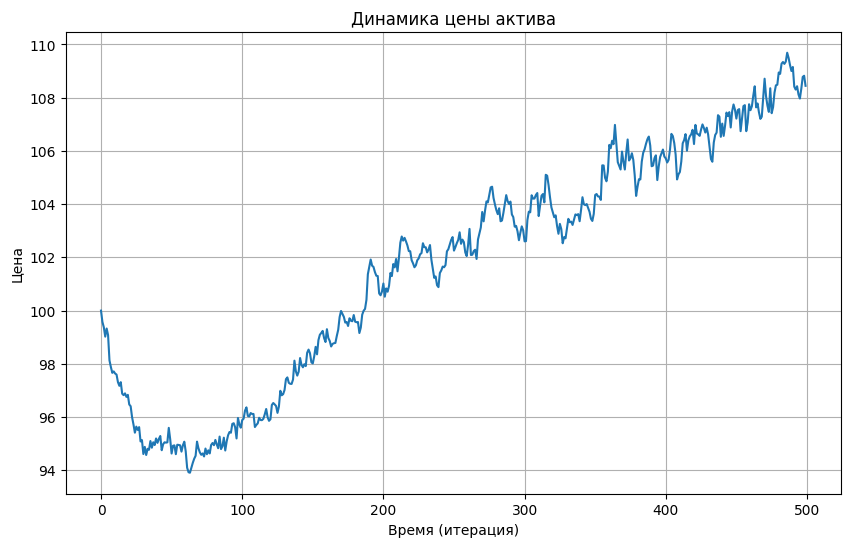

In [7]:
price = pd.Series(engine.stats_monitor.prices)
price.plot(
    title="Динамика цены актива",
    ylabel="Цена",
    xlabel="Время (итерация)",
    grid=True,
    figsize=(10, 6),
);

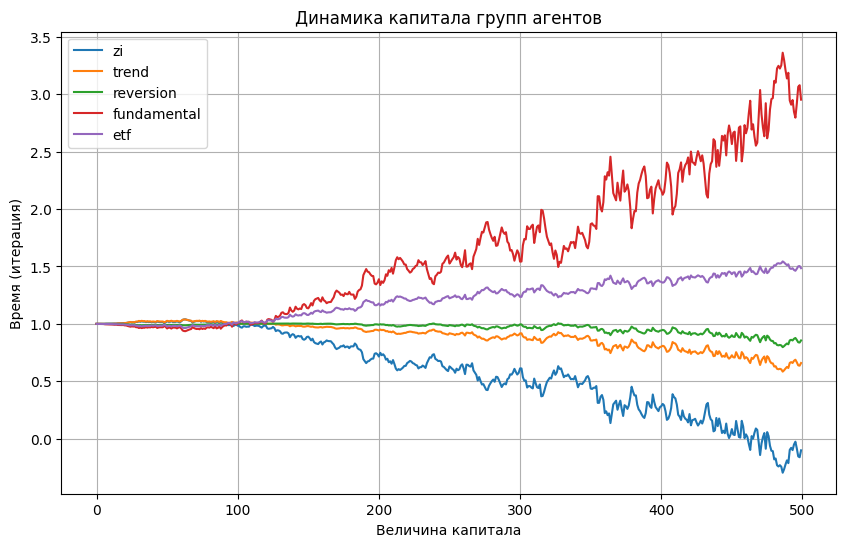

In [8]:
equity = pd.DataFrame(
    [
        [
            bs[ZeroIntelligenceTrader]["total_equity"],
            bs[TrendTrader]["total_equity"],
            bs[MeanReversionTrader]["total_equity"],
            bs[FundamentalTrader]["total_equity"],
            bs[ETFTrader]["total_equity"],
        ]
        for bs in engine.stats_monitor.balance_stats
    ],
    columns=["zi", "trend", "reversion", "fundamental", "etf"],
)
(equity / equity.iloc[0].to_numpy()[None, :]).plot(
    title="Динамика капитала групп агентов",
    xlabel="Величина капитала",
    ylabel="Время (итерация)",
    grid=True,
    figsize=(10, 6),
);